# Tutorial on fitting with `ticktack` and `emcee`

Let's go through an example of how you would fit the original Miyake event time series from 774 AD ([Miyake et al, 2012](https://www.nature.com/articles/nature11123)) using tools from `ticktack`. First we import everything.

In [1]:
import numpy as np
import ticktack
from ticktack import fitting
from jax import jit
import jax.numpy as jnp

Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler14'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')

Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm)
sf.load_data('miyake12.csv')
sf.prepare_function(model="simple_sinusoid")

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this, where params are (arrival time in years, duration in years, solar cycle phase in radians, and total radiocarbon delivered in production rate times years).

In [4]:
@jit
def log_prior(params=()):
    lp = jnp.sum(jnp.where((params<=0), -np.inf, 0))
    return lp

@jit
def log_prob(params=()):
    lp = log_prior(params=params)
    pos = cf.log_like(params=params)
    return lp + pos

In [5]:
%%time
default_params = np.array([775., 1./12, np.pi/2., 81./12])
sampler = sf.sampling(default_params, likelihood=sf.log_joint_simple_sinusoid, burnin=500, production=1000)

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.50it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.68it/s]

CPU times: user 59 s, sys: 781 ms, total: 59.8 s
Wall time: 57.9 s


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

Gelman-Rubin Statistic values for chain Chain 0
Start Date (yr): 1.04688 (Passed)
Duration (yr): 1.03573 (Passed)
phi (yr): 1.02752 (Passed)
Area: 1.02234 (Passed)
Gweke Statistic for chain Chain 0 has p-value 4.092243e-02
Convergence: False


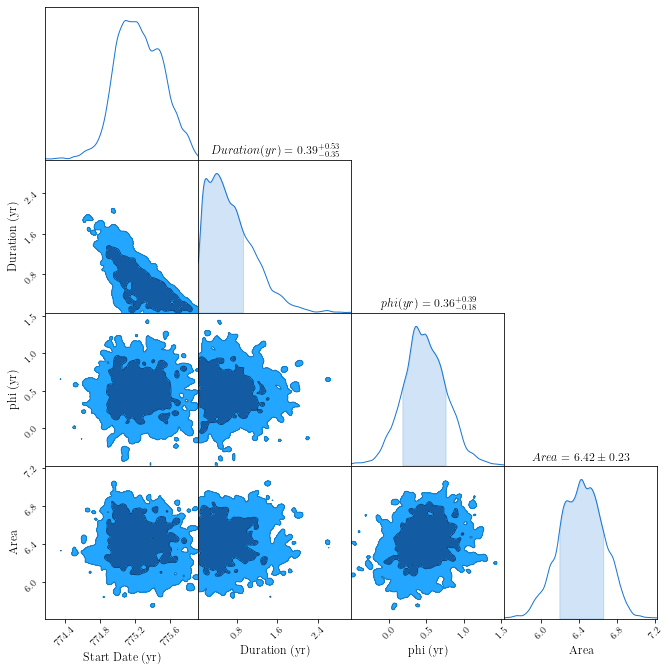

In [6]:
labels = ["Start Date (yr)", "Duration (yr)", "phi (yr)", "Area"]
fig = sf.chain_summary(sampler, 20, labels=labels)

And a plot of models evaluated from samples of the posterior parameters shows a pretty good fit!

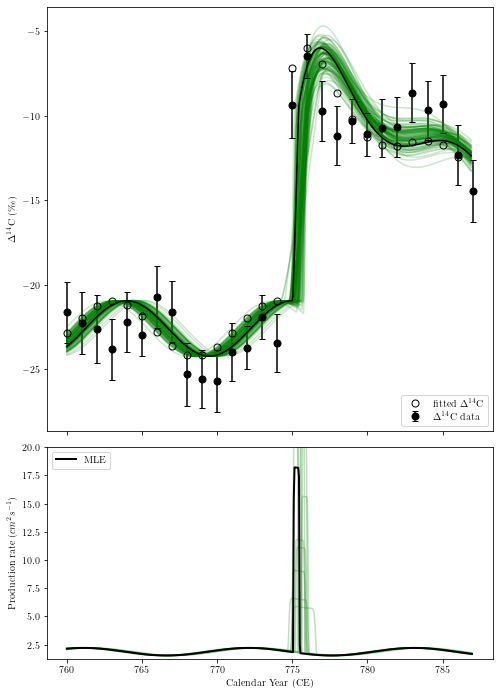

In [7]:
sf.plot_samples(sampler, 20)